# Working With COG - At Scale

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/developmentseed/titiler/main?filepath=docs%2Fexamples%2F%2Fnotebooks%2FWorking_with_CloudOptimizedGeoTIFF.ipynb)

For this demo we will use the new `Ozone Monitoring Instrument (OMI) / Aura NO2 Tropospheric Column Density` dataset hosted on AWS PDS: https://registry.opendata.aws/omi-no2-nasa/

Requirement: AWS credentials

#### Requirements
- AWS credentials
- rasterio
- folium
- httpx
- tqdm

`!pip install rasterio boto3 folium httpx tqdm`

In [ ]:
# Uncomment this line if you need to install the dependencies
# !pip install rasterio boto3 folium requests tqdm

In [13]:
import os
import datetime
import json
import urllib.parse
from io import BytesIO
from functools import partial
from concurrent import futures

import httpx
import numpy
from boto3.session import Session as boto3_session

from rasterio.plot import reshape_as_image
from rasterio.features import bounds as featureBounds

from tqdm.notebook import tqdm

from folium import Map, TileLayer, GeoJson

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
titiler_endpoint = "https://titiler.xyz"  # Developmentseed Demo endpoint. Please be kind.

## Define your area of interest (AOI)

In [3]:
# use geojson.io
geojson = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -74.1796875,
              45.18978009667531
            ],
            [
              -73.092041015625,
              45.18978009667531
            ],
            [
              -73.092041015625,
              46.00459325574482
            ],
            [
              -74.1796875,
              46.00459325574482
            ],
            [
              -74.1796875,
              45.18978009667531
            ]
          ]
        ]
      }
    }
  ]
}

bounds = featureBounds(geojson)

In [4]:
m = Map(
    tiles="OpenStreetMap",
    location=((bounds[1] + bounds[3]) / 2,(bounds[0] + bounds[2]) / 2),
    zoom_start=6
)

GeoJson(geojson).add_to(m)
m

## List available files on AWS S3

In [ ]:
# To Be able to run this notebook you'll need to have AWS credential available in the environment

# import os
# os.environ["AWS_ACCESS_KEY_ID"] = "YOUR AWS ACCESS ID HERE"
# os.environ["AWS_SECRET_ACCESS_KEY"] = "YOUR AWS ACCESS KEY HERE"

In [6]:
session = boto3_session(region_name="us-west-2")
client = session.client("s3")

bucket = "omi-no2-nasa"  #https://registry.opendata.aws/omi-no2-nasa/


def list_objects(bucket, prefix):
    """AWS s3 list objects."""

    paginator = client.get_paginator('list_objects_v2')

    files = []
    for subset in paginator.paginate(Bucket=bucket, Prefix=prefix):
        files.extend(subset.get("Contents", []))

    return files

list_files = list_objects(bucket, "OMI-Aura_L3")

print("Archive Size")
files = [r["Key"] for r in list_files]
print(f"Found {len(files)} OMI-NO2 files")

size = sum([r["Size"]/1000000. for r in list_files])
print(f"Size of the archive: {size} Mo ({size / 1000} Go)")

Archive Size
Found 5688 OMI-NO2 files
Size of the archive: 15560.884343999986 Mo (15.560884343999986 Go)


In [ ]:
print(files[0:10])

file name structure is `"OMI-Aura_L3-OMNO2d_{YEAR}m{MONTH:02}{DAY:02}..."`

We can then easily filter e.g 

In [7]:
files_2019 = list(filter(lambda x: x.split("_")[2][0:4] == "2019", files))
print(len(files_2019))

365


In [8]:
files_Oct5 = list(filter(lambda x: (x.split("_")[2][5:7] == "10") & (x.split("_")[2][7:9] == "05"), files))
print(len(files_Oct5))
print(files_Oct5)

16
['OMI-Aura_L3-OMNO2d_2004m1005_v003-2019m1121t083127.tif', 'OMI-Aura_L3-OMNO2d_2005m1005_v003-2019m1120t222137.tif', 'OMI-Aura_L3-OMNO2d_2006m1005_v003-2019m1121t041524.tif', 'OMI-Aura_L3-OMNO2d_2007m1005_v003-2019m1121t101933.tif', 'OMI-Aura_L3-OMNO2d_2008m1005_v003-2019m1121t164133.tif', 'OMI-Aura_L3-OMNO2d_2009m1005_v003-2019m1121t211205.tif', 'OMI-Aura_L3-OMNO2d_2010m1005_v003-2019m1122t022154.tif', 'OMI-Aura_L3-OMNO2d_2011m1005_v003-2019m1122t054850.tif', 'OMI-Aura_L3-OMNO2d_2012m1005_v003-2019m1122t075810.tif', 'OMI-Aura_L3-OMNO2d_2013m1005_v003-2019m1122t125824.tif', 'OMI-Aura_L3-OMNO2d_2014m1005_v003-2019m1122t164301.tif', 'OMI-Aura_L3-OMNO2d_2015m1005_v003-2019m1122t203759.tif', 'OMI-Aura_L3-OMNO2d_2016m1005_v003-2019m1123t024953.tif', 'OMI-Aura_L3-OMNO2d_2017m1005_v003-2019m1123t050945.tif', 'OMI-Aura_L3-OMNO2d_2018m1005_v003-2019m1123t090601.tif', 'OMI-Aura_L3-OMNO2d_2019m1005_v003-2020m0428t113315.tif']


### DATA Endpoint

`{endpoint}/cog/tiles/{z}/{x}/{y}.{format}?url={cog}&{otherquery params}`


`{endpoint}/cog/crop/{minx},{miny},{maxx},{maxy}.{format}?url={cog}&{otherquery params}`


`{endpoint}/cog/point/{minx},{miny}?url={cog}&{otherquery params}`


### Visualize One Item

In [9]:
def _url(src_path):
    return f"s3://omi-no2-nasa/{src_path}"

In [10]:
# Fetch File Metadata to get min/max rescaling values (because the file is stored as float32)

r = httpx.get(
    f"{titiler_endpoint}/cog/statistics",
    params = {
        "url": _url(files[0])
    }
).json()

print(json.dumps(r, indent=4))

{
    "b1": {
        "min": -1.1083295177572352e+16,
        "max": 7.240744489399091e+16,
        "mean": 351677915275206.25,
        "count": 363556.0,
        "sum": 1.2785461616579287e+20,
        "std": 1005013765073390.0,
        "median": 137491633930240.0,
        "majority": 102650943111168.0,
        "minority": -1.1083295177572352e+16,
        "unique": 356942.0,
        "histogram": [
            [
                153.0,
                361369.0,
                1785.0,
                206.0,
                27.0,
                12.0,
                3.0,
                0.0,
                0.0,
                1.0
            ],
            [
                -1.1083295177572352e+16,
                -2734221277790208.0,
                5614852621991936.0,
                1.396392652177408e+16,
                2.231300149529805e+16,
                3.066207432133837e+16,
                3.901114929486234e+16,
                4.736022212090266e+16,
                5.570929

In [12]:
r = httpx.get(
    f"{titiler_endpoint}/cog/tilejson.json",
    params = {
        "url": _url(files[2]),
        "rescale": "0,3000000000000000",
        "colormap_name": "viridis",
    }
).json()

m = Map(
    location=((bounds[1] + bounds[3]) / 2,(bounds[0] + bounds[2]) / 2),
    zoom_start=6
)

TileLayer(
    tiles=r["tiles"][0],
    opacity=1,
    attr="NASA"
).add_to(m)

GeoJson(geojson, style_function=lambda feature: {"fill": False, "color": "red"}).add_to(m)

m

### Create time series of NO2

In [16]:
def _stats(data, mask):
    arr = numpy.ma.array(data)
    arr.mask = mask == 0
    return arr.min().item(), arr.max().item(), arr.mean().item(), arr.std().item()


xmin, ymin, xmax, ymax = bounds

def fetch_bbox(file):
    url = f"{titiler_endpoint}/cog/bbox/{xmin},{ymin},{xmax},{ymax}.npy"
    params = {
        "url": _url(file),
        "bidx": "1",
        "max_size": 128,
    }
    r = httpx.get(url, params=params)
    data = numpy.load(BytesIO(r.content))
    s = _stats(data[0:-1], data[-1])
    return (
        _stats(data[0:-1], data[-1]), 
        datetime.datetime.strptime(file.split("_")[2].replace("m", ""), "%Y%m%d"),
    )

# small tool to filter invalid response from the API
def _filter_futures(tasks):
    for future in tasks:
        try:
            yield future.result()
        except Exception:
            pass

## Get NO2 Max for day 15th of each month

In [17]:
# Every 15 of each month for all the years
files_15 = list(filter(lambda x: (x.split("_")[2][7:9] == "15"), files))

  0%|          | 0/187 [00:00<?, ?it/s]

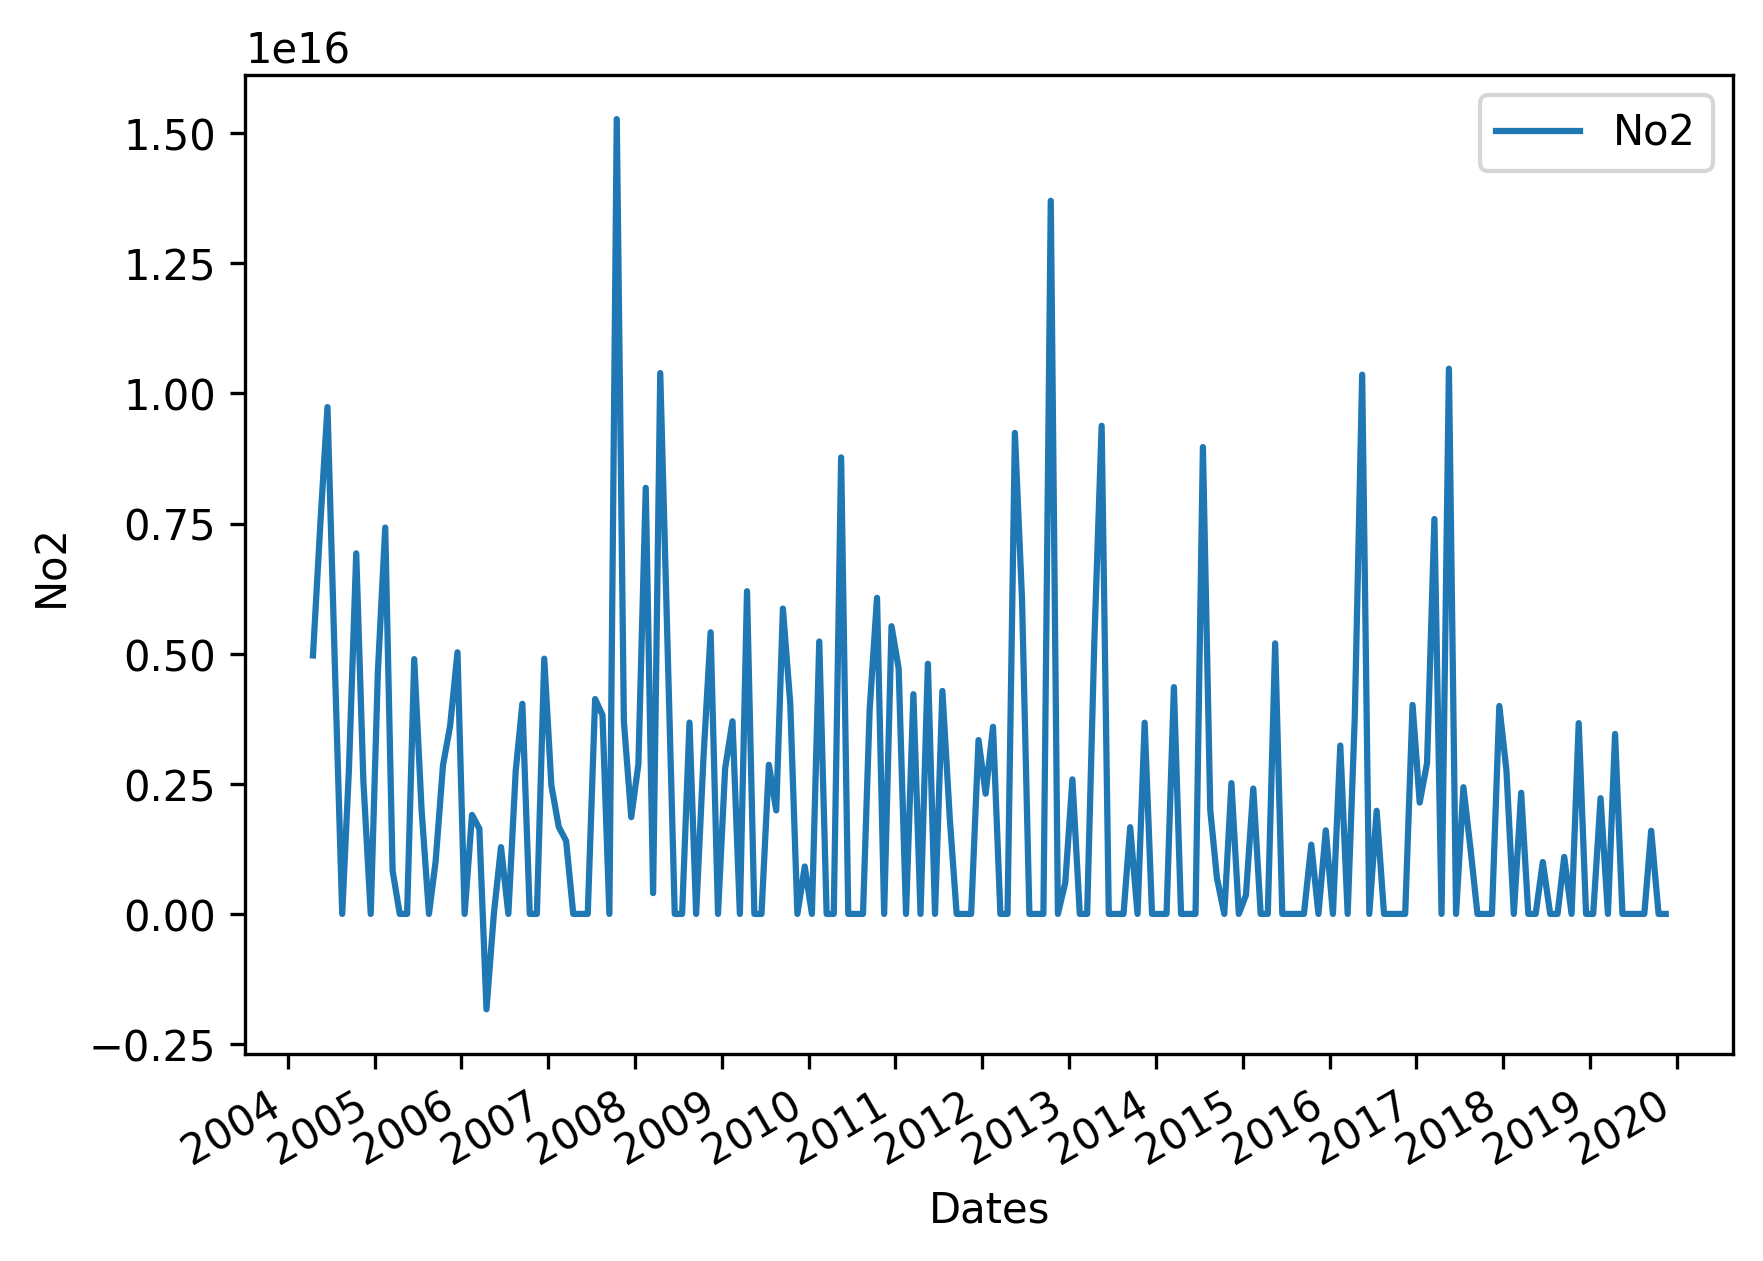

In [18]:
with futures.ThreadPoolExecutor(max_workers=10) as executor:
    future_work = [
        executor.submit(fetch_bbox, file) for file in files_15
    ]

    for f in tqdm(futures.as_completed(future_work), total=len(future_work)):               
        pass

values, dates  = zip(*list(_filter_futures(future_work)))

max_values = [
    v[1]
    for v in values
]

fig, ax1 = plt.subplots(dpi=300)
fig.autofmt_xdate()

ax1.plot(dates, max_values, label="No2")
ax1.xaxis.set_major_locator(mdates.YearLocator(1,7))

ax1.set_xlabel("Dates")
ax1.set_ylabel("No2")

ax1.legend()

## Same but for all the days for the last 16 years

  0%|          | 0/5688 [00:00<?, ?it/s]

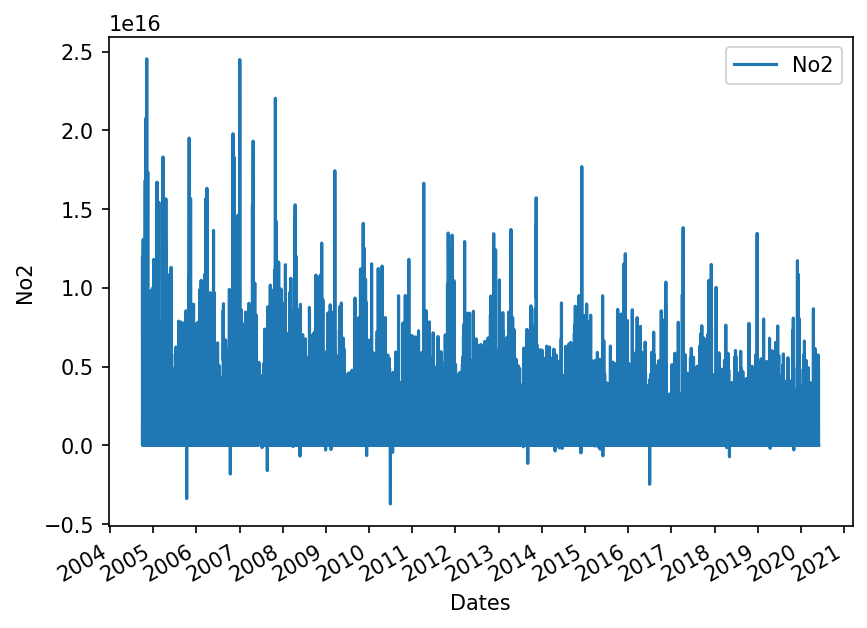

In [19]:
with futures.ThreadPoolExecutor(max_workers=50) as executor:
    future_work = [
        executor.submit(fetch_bbox, file) for file in files
    ]

    for f in tqdm(futures.as_completed(future_work), total=len(future_work)):               
        pass

values, dates  = zip(*list(_filter_futures(future_work)))

max_values = [
    v[1]
    for v in values
]

fig, ax1 = plt.subplots(dpi=150)
fig.autofmt_xdate()

ax1.plot(dates, max_values, label="No2")
ax1.xaxis.set_major_locator(mdates.YearLocator())

ax1.set_xlabel("Dates")
ax1.set_ylabel("No2")

ax1.legend()